__Цель работы:__

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

__Описание этапа обработки__

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

# Проект: Предсказание температуры 

## 0. Подготовка

### 0.1. План работы. 

0. Подготовка <br>

0.1. План работы.  <br>
0.2. Импорт библиотек, используемых в проекте.  <br>
0.3. Повторяющийся код - заготовка функций.  <br>

1. Анализ исходных данных.  <br>

1.1. Поиск аномальных и отработка пропущенных значений в исходных данных.  <br>

1.2. Наполнение датасета для моделирования.  <br>
1.2.1. Формируем целевую переменную.  <br>
1.2.2. Формируем признаки.  <br>
1.2.2.1. Начальная температура.  <br>
1.2.2.2. Суммарная активная, реактивная энергия по каждой партии,  суммарная длительность подачи электроэнергии для нагрева.  <br>
1.2.2.3. Подача газа.  <br>
1.2.2.4 Применение сыпучих материалов.  <br>
1.2.2.5 Применение проволных материалов.  <br>
1.2.2.6. Затраты активной и реактивной электроэнергии для каждой партии. <br>
1.3 Проверка полученного датасета.  <br>
1.3.1. Пропуски, артефактные значения.  <br>
1.3.2. Проверка на мультиколлиярность.  <br>
1.4. Вывод по первому разделу. <br>

2. Моделирование.  <br>

2.1. Разделение данных на выборки.  <br>
2.2. Обучение моделей.  <br>
2.2.1. Линейная регрессия.  <br>
2.2.2. RandomForestRegressor. <br>
2.2.3. CatBoostRegressor.  <br>
2.2.4. Нейронная сеть.  <br>
2.3. Сводная таблица результатов.  <br>
2.4. Оценка значимости признаков.  <br>
2.5. Вывод по второму разделу. <br>

3. Отчёт по проделанной работе.  <br>

### 0.2. Импорт библиотек, используемых в проекте. 

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')

2022-09-22 06:50:32.983457: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-22 06:50:33.140064: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-22 06:50:33.140098: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-22 06:50:33.174387: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-22 06:50:34.054443: W tensorflow/stream_executor/pla

### 0.3. Повторяющийся код - заготовка функций. 

In [3]:
def check_dataset(label : str, data : pd.DataFrame) -> None:
    """Вывод важных параметров исследуемого датасета."""
    print(f'________ Рассматриваем датасет {label} ________')
    print('--------------------------------------------------------------')
    print(f'Размерность: {data.shape}')
    print(f'Дублирующих записей: {data.duplicated().sum() / len(data)} %')
    print('Пример датасета:')
    display(data.head())
    print('--------------------------------------------------------------')
    res = pd.DataFrame()
    res['type'] = data.dtypes
    res['Uniq'] = data.nunique() / len(data)
    res['NaN'] = data.isna().sum() / len(data)
    res = res.merge(data.describe(percentiles = [.01, .25, .5, .75, .99]).T, 
                    how = 'left', 
                    left_index = True, 
                    right_index = True)
    res = res.sort_values(by = 'type')
    columns_cat = res.loc[res['type'] == 'object'].index
    res = res.style.background_gradient(axis=1, subset = ['Uniq', 'NaN'], cmap='Blues', vmin = 0.01, vmax = 1)
    display(res)
    print('////////////////////////////////////////////////////////////////')
    print()

In [4]:
def get_hist_and_boxplot(series : pd.Series, bins : int = None) -> None:
    """Получение гистрограммы и boxplot для Series."""
    fig, ax = plt.subplots(1, 2, figsize = (15, 7.5))
    fig.suptitle(series.name)
    series.hist(bins = bins, ax = ax[0])
    series.plot.box(ax = ax[1])

In [5]:
def apply_search_param_model(pipe : list[tuple], 
                             param_grid : dict,
                             features : pd.DataFrame,
                             target : pd.Series,
                             label_dataset : str,
                             scoring : str = 'neg_mean_absolute_error') -> None:
    
    search_model = GridSearchCV(estimator = pipe,
                                   param_grid = parameters,
                                   cv = 5, return_train_score=True, scoring = scoring, error_score='raise')
    search_model.fit(features_train, target_train)
    get_row_to_result(search_model, label_dataset)
    print("Best: %f using %s" %(search_model.best_score_, search_model.best_params_))

In [6]:
def get_row_to_result(model : GridSearchCV, label_dataset :str) -> None:
    """Добавление строки в отчёт."""
    global result
    global list_model
    list_model.append(model)
    result = result.append({"name_model" : model.get_params()['estimator__estimator'].__class__.__name__ , 
                            "parametrs" : model.best_params_, 
                            "score" : model.best_score_,
                            "used_dataset" : label_dataset},
                            ignore_index = True)

## 1. Анализ исходных данных. 

### 1.1. Поиск аномальных и отработка пропущенных значений в исходных данных. 

Загрузка данных: 

In [7]:
try:
    data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
    data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
    data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
    data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')
except:
    data_arc = pd.read_csv('final_steel/data_arc.csv')
    data_bulk = pd.read_csv('final_steel/data_bulk.csv')
    data_bulk_time = pd.read_csv('final_steel/data_bulk_time.csv')
    data_gas = pd.read_csv('final_steel/data_gas.csv')
    data_temp = pd.read_csv('final_steel/data_temp.csv')
    data_wire = pd.read_csv('final_steel/data_wire.csv')
    data_wire_time = pd.read_csv('final_steel/data_wire_time.csv')

dict_dataset = {'data_arc' : (data_arc, 'Данные об электродах'),
                'data_bulk' : (data_bulk, 'Данные о подаче сыпучих материалов (объём)'),
                'data_bulk_time' : (data_bulk_time, 'Данные о подаче сыпучих материалов (время)'),
                'data_gas' : (data_gas, 'Данные о продувке сплава газом'),
                'data_temp' : (data_temp, 'Результаты измерения температуры'),
                'data_wire' : (data_wire, 'Данные о проволочных материалах (объём)'),
                'data_wire_time' : (data_wire_time, 'Данные о проволочных материалах (время)')
                }

Выведем первичный отчёт для всех датасетов: 

In [8]:
for key, value in dict_dataset.items():
    check_dataset(value[1], value[0])

________ Рассматриваем датасет Данные об электродах ________
--------------------------------------------------------------
Размерность: (14876, 5)
Дублирующих записей: 0.0 %
Пример датасета:


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


--------------------------------------------------------------


,type,Uniq,NaN,count,mean,std,min,1%,25%,50%,75%,99%,max
key,int64,0.216053,0.000000,14876.000000,1615.220422,934.571502,1.000000,33.000000,806.000000,1617.000000,2429.000000,3205.000000,3241.000000
Активная мощность,float64,0.999529,0.000000,14876.000000,0.670441,0.408159,0.030002,0.112734,0.395297,0.555517,0.857034,2.079994,3.731596
Реактивная мощность,float64,0.999328,0.000000,14876.000000,0.452592,5.878702,-715.504924,0.080714,0.290991,0.415962,0.637371,1.592817,2.676388
Начало нагрева дугой,object,0.999933,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Конец нагрева дугой,object,1.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


////////////////////////////////////////////////////////////////

________ Рассматриваем датасет Данные о подаче сыпучих материалов (объём) ________
--------------------------------------------------------------
Размерность: (3129, 16)
Дублирующих записей: 0.0 %
Пример датасета:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


--------------------------------------------------------------


,type,Uniq,NaN,count,mean,std,min,1%,25%,50%,75%,99%,max
key,int64,1.000000,0.000000,3129.000000,1624.383509,933.337642,1.000000,32.280000,816.000000,1622.000000,2431.000000,3208.720000,3241.000000
Bulk 1,float64,0.015021,0.919463,252.000000,39.242063,18.277654,10.000000,17.530000,27.000000,31.000000,46.000000,98.900000,185.000000
Bulk 2,float64,0.004794,0.992969,22.000000,253.045455,21.180578,228.000000,228.000000,242.000000,251.500000,257.750000,315.970000,325.000000
Bulk 3,float64,0.088846,0.585171,1298.000000,113.879045,75.483494,6.000000,19.000000,58.000000,97.500000,152.000000,343.180000,454.000000
Bulk 4,float64,0.065836,0.675935,1014.000000,104.394477,48.184126,12.000000,19.000000,72.000000,102.000000,133.000000,239.000000,281.000000
Bulk 5,float64,0.017578,0.975391,77.000000,107.025974,81.790646,11.000000,16.320000,70.000000,86.000000,132.000000,367.400000,603.000000
Bulk 6,float64,0.065516,0.815916,576.000000,118.925347,72.057776,17.000000,25.000000,69.750000,100.000000,157.000000,351.750000,503.000000
Bulk 7,float64,0.007990,0.992010,25.000000,305.600000,191.022904,47.000000,47.720000,155.000000,298.000000,406.000000,724.960000,772.000000
Bulk 8,float64,0.000320,0.999680,1.000000,49.000000,nan,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
Bulk 9,float64,0.003196,0.993928,19.000000,76.315789,21.720581,63.000000,63.360000,66.000000,68.000000,70.500000,140.520000,147.000000


////////////////////////////////////////////////////////////////

________ Рассматриваем датасет Данные о подаче сыпучих материалов (время) ________
--------------------------------------------------------------
Размерность: (3129, 16)
Дублирующих записей: 0.0 %
Пример датасета:


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


--------------------------------------------------------------


,type,Uniq,NaN,count,mean,std,min,1%,25%,50%,75%,99%,max
key,int64,1.000000,0.000000,3129.000000,1624.383509,933.337642,1.000000,32.280000,816.000000,1622.000000,2431.000000,3208.720000,3241.000000
Bulk 1,object,0.080537,0.919463,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Bulk 2,object,0.007031,0.992969,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Bulk 3,object,0.414829,0.585171,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Bulk 4,object,0.324065,0.675935,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Bulk 5,object,0.024609,0.975391,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Bulk 6,object,0.184084,0.815916,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Bulk 7,object,0.007990,0.992010,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Bulk 8,object,0.000320,0.999680,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Bulk 9,object,0.006072,0.993928,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


////////////////////////////////////////////////////////////////

________ Рассматриваем датасет Данные о продувке сплава газом ________
--------------------------------------------------------------
Размерность: (3239, 2)
Дублирующих записей: 0.0 %
Пример датасета:


,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


--------------------------------------------------------------


,type,Uniq,NaN,count,mean,std,min,1%,25%,50%,75%,99%,max
key,int64,1.000000,0.000000,3239.000000,1621.861377,935.386334,1.000000,33.380000,812.500000,1622.000000,2431.500000,3208.620000,3241.000000
Газ 1,float64,1.000000,0.000000,3239.000000,11.002062,6.220327,0.008399,1.132655,7.043089,9.836267,13.769915,31.558630,77.995040


////////////////////////////////////////////////////////////////

________ Рассматриваем датасет Результаты измерения температуры ________
--------------------------------------------------------------
Размерность: (15907, 3)
Дублирующих записей: 0.0 %
Пример датасета:


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


--------------------------------------------------------------


,type,Uniq,NaN,count,mean,std,min,1%,25%,50%,75%,99%,max
key,int64,0.202175,0.000000,15907.000000,1607.880870,942.212073,1.000000,29.000000,790.000000,1618.000000,2427.000000,3205.000000,3241.000000
Температура,float64,0.011001,0.182373,13006.000000,1591.840920,21.375851,1191.000000,1544.000000,1581.000000,1591.000000,1601.000000,1654.000000,1705.000000
Время замера,object,1.000000,0.000000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


////////////////////////////////////////////////////////////////

________ Рассматриваем датасет Данные о проволочных материалах (объём) ________
--------------------------------------------------------------
Размерность: (3081, 10)
Дублирующих записей: 0.0 %
Пример датасета:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------------------------------


,type,Uniq,NaN,count,mean,std,min,1%,25%,50%,75%,99%,max
key,int64,1.000000,0.000000,3081.000000,1623.426485,932.996726,1.000000,31.800000,823.000000,1619.000000,2434.000000,3210.200000,3241.000000
Wire 1,float64,0.730607,0.008439,3055.000000,100.895853,42.012518,1.918800,13.060320,72.115684,100.158234,126.060483,209.267394,330.314424
Wire 2,float64,0.231418,0.649789,1079.000000,50.577323,39.320216,0.030160,4.125285,20.193680,40.142956,70.227558,181.311065,282.780152
Wire 3,float64,0.018176,0.979552,63.000000,189.482681,99.513444,0.144144,0.144144,95.135044,235.194977,276.252014,349.188221,385.008668
Wire 4,float64,0.004544,0.995456,14.000000,57.442841,28.824667,24.148801,24.276700,40.807002,45.234282,76.124619,111.905543,113.231044
Wire 5,float64,0.000325,0.999675,1.000000,15.132000,nan,15.132000,15.132000,15.132000,15.132000,15.132000,15.132000,15.132000
Wire 6,float64,0.022395,0.976306,73.000000,48.016974,33.919845,0.034320,0.108451,25.053600,42.076324,64.212723,155.027565,180.454575
Wire 7,float64,0.003246,0.996430,11.000000,10.039007,8.610584,0.234208,0.316181,6.762756,9.017009,11.886057,30.798354,32.847674
Wire 8,float64,0.004219,0.993833,19.000000,53.625193,16.881728,45.076721,45.076721,46.094879,46.279999,48.089603,101.409133,102.762401
Wire 9,float64,0.008114,0.990587,29.000000,34.155752,19.931616,4.622800,5.499313,22.058401,30.066399,43.862003,82.491139,90.053604


////////////////////////////////////////////////////////////////

________ Рассматриваем датасет Данные о проволочных материалах (время) ________
--------------------------------------------------------------
Размерность: (3081, 10)
Дублирующих записей: 0.0 %
Пример датасета:


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


--------------------------------------------------------------


,type,Uniq,NaN,count,mean,std,min,1%,25%,50%,75%,99%,max
key,int64,1.000000,0.000000,3081.000000,1623.426485,932.996726,1.000000,31.800000,823.000000,1619.000000,2434.000000,3210.200000,3241.000000
Wire 1,object,0.991561,0.008439,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Wire 2,object,0.350211,0.649789,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Wire 3,object,0.020448,0.979552,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Wire 4,object,0.004544,0.995456,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Wire 5,object,0.000325,0.999675,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Wire 6,object,0.023694,0.976306,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Wire 7,object,0.003570,0.996430,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Wire 8,object,0.006167,0.993833,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Wire 9,object,0.009413,0.990587,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


////////////////////////////////////////////////////////////////



Основные моменты от первичного анализа: <br>
* Определено, что данные о подаче сыпучих материалов (время) и данные о подаче проволчных материалов (время) не несут для нас никакой информативности. Поэтому о них мы можем забыть. <br>

* Замечана аномалия в данных о электродах, реактивная энергия - минимальное значение -715.5 - исключим это из анализа. 

In [9]:
data_arc = data_arc[data_arc['key'] != data_arc[data_arc['Реактивная мощность'] < 0]['key'].values[0]]

* В данных о объёмах подачи, много пропущенных значений. Уверен, что если значение пропущено, значит просто не подается материал. Заменим пропущенные значения на 0. 

In [10]:
data_bulk = data_bulk.fillna(0)
data_wire = data_wire.fillna(0)

* Мы будем использовать даты, приведем их тип к необходимому. 

In [11]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'])
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'])

data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'])

Теперь более детально с визуализацией посмотрим распределение некоторых величин: 

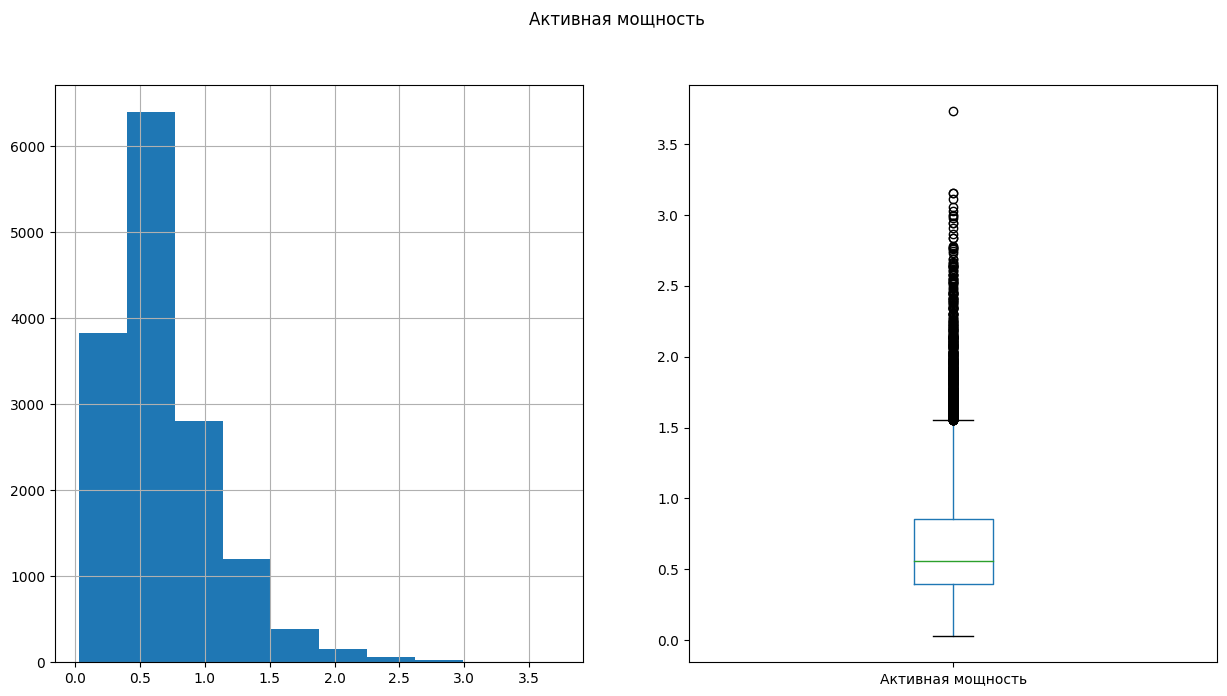

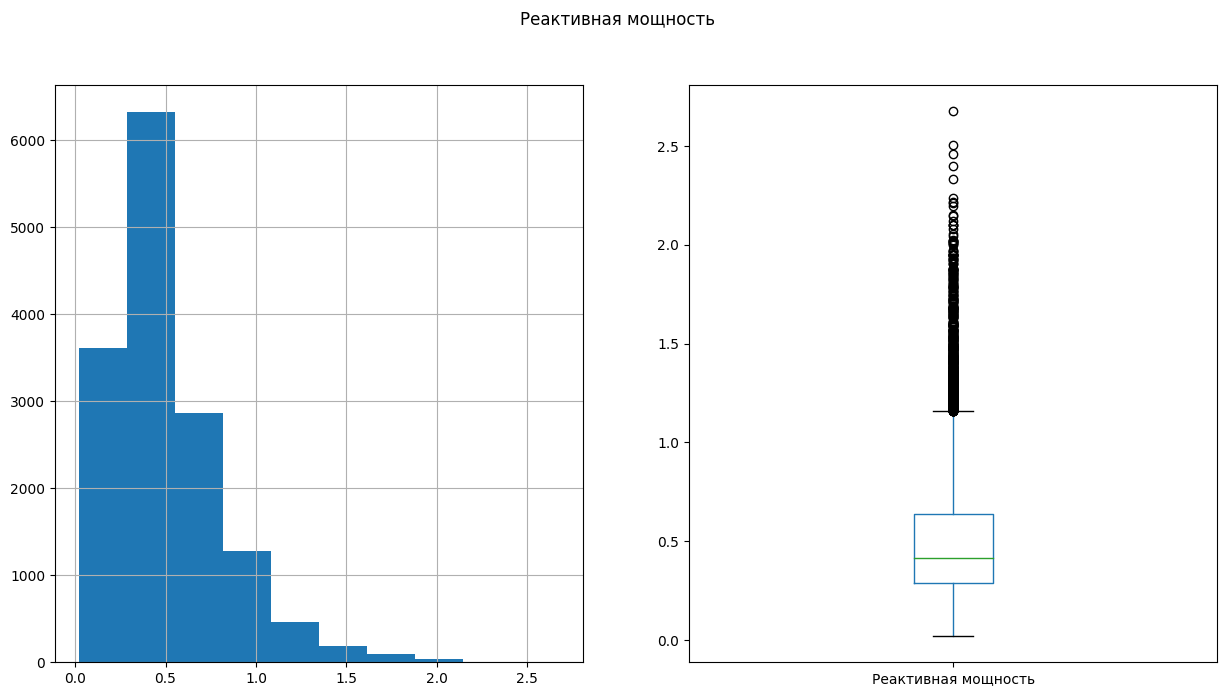

In [12]:
get_hist_and_boxplot(data_arc['Активная мощность'])
get_hist_and_boxplot(data_arc['Реактивная мощность'])

Имеется скос в левую сторону на графиках мощности, исправим это позже с помощью **логарифмирования**

### 1.2. Наполнение датасета для моделирования. 

Для нас, каждым новым объектов для исследования будет являться каждая партия, замаркированная ключом "key" в каждом датасете. <br>
Создадим пустой датасет, который в скором мы наполним. 

In [13]:
dataset = pd.DataFrame()

#### 1.2.1. Формируем целевую переменную. 

Целевой переменой является последний замер температуры сплава:

In [14]:
data_temp['max_time'] = data_temp.groupby('key')[['Время замера']].transform('max')
dataset = data_temp.loc[data_temp['Время замера'] == data_temp['max_time'], ['key', 'Температура']].set_index('key').rename(columns = {'Температура' : 'temperature'})

#### 1.2.2. Формируем признаки. 

Этот раздел посвящен извлечению признаков. 

##### 1.2.2.1. Начальная температура. 

Аналогично тому, как мы выделили последнюю температуру, мы можем выделить первую (начальную) температуру сплава и использовать её в качестве признака: 

In [15]:
data_temp['init_time'] = data_temp.groupby('key')['Время замера'].transform('min')
dataset = (data_temp.loc[data_temp['Время замера'] == data_temp['init_time'], ['key', 'Температура']]
                    .set_index('key')
                    .rename(columns = {'Температура' : 'init_temperature'})
          ).merge(dataset, how = 'outer', left_index=True, right_index=True)

##### 1.2.2.2. Суммарная активная, реактивная энергия по каждой партии,  суммарная длительность подачи электроэнергии для нагрева. 

Извлечем суммарные показания используемых мощностей и длительности применения этих мощностей. <br>
Промежутки времени представим в виде часов. 

In [16]:
data_arc['duration'] = (data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']) / pd.Timedelta(hours = 1)
dataset = (data_arc.groupby('key')[['Активная мощность', 'Реактивная мощность']].sum()
          .merge(dataset, how = 'outer', left_index=True, right_index=True))

dataset['duration_nagr'] = data_arc.groupby('key')['duration'].sum()
dataset = dataset.rename(columns = {'Активная мощность' : 'power_active', 'Реактивная мощность' : 'power_reactive'})

##### 1.2.2.3. Подача газа. 

Добавим сколько газа, подавалось в каждую партию. 

In [17]:
dataset = (data_gas.set_index('key')
                   .merge(dataset, how = 'outer', left_index=True, right_index=True)
                   .rename(columns = {'Газ 1' : 'gas'}))

##### 1.2.2.4 Применение сыпучих материалов. 

Выглядит малоинформативно, много нулей, но пока нам необходимы все данные о подаваемых объёмах. 

In [18]:
dataset = data_bulk.set_index('key').merge(dataset, how = 'outer', left_index=True, right_index=True)

##### 1.2.2.5 Применение проволных материалов.

Аналогично, добавим и о подаче проволочных материалов

In [19]:
dataset = data_wire.set_index('key').merge(dataset, how = 'outer', left_index=True, right_index=True)

##### 1.2.2.6. Затраты активной и реактивной электроэнергии для каждой партии.

Данные фичи, очень важны, мы перемножим мощность на время использования, получив затраты электроэнергии. Эти фичи будет коррелировать со своими компонентами, поэтому вынесем в отдельный датасет. 

In [20]:
dataset_2 = dataset.drop(columns = ['power_active', 'power_reactive', 'duration_nagr']).copy()

In [21]:
data_arc['active_electricity'] = data_arc['Активная мощность'] * data_arc['duration']
data_arc['reactive_electricity'] = data_arc['Реактивная мощность'] * data_arc['duration'] 

dataset_2 = (data_arc.groupby('key')[['active_electricity', 'reactive_electricity']].sum()
           .merge(dataset_2, how = 'outer', left_index=True, right_index=True))

In [22]:
dataset_2

,active_electricity,reactive_electricity,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,init_temperature,temperature
key,,,,,,,,,,,,,,,,,,,,,
1,0.335501,0.218863,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,1571.0,1613.0
2,0.203838,0.135442,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1581.0,1602.0
3,0.123218,0.078038,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1596.0,1599.0
4,0.186295,0.119427,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,1601.0,1625.0
5,0.277082,0.184706,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3237,0.216109,0.155371,38.088959,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,252.0,0.0,130.0,206.0,5.543905,1569.0,NaN
3238,0.120236,0.096762,56.128799,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,254.0,0.0,108.0,106.0,6.745669,1584.0,NaN
3239,0.234716,0.154990,143.357761,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,158.0,0.0,270.0,88.0,16.023518,1598.0,NaN


### 1.3 Проверка полученного датасета. 

#### 1.3.1. Пропуски, артефактные значения. 

In [23]:
init_len = dataset.shape[0]

In [24]:
check_dataset('one', dataset)

________ Рассматриваем датасет one ________
--------------------------------------------------------------
Размерность: (3241, 30)
Дублирующих записей: 0.0 %
Пример датасета:


,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Bulk 1,...,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,power_active,power_reactive,init_temperature,temperature,duration_nagr
key,,,,,,,,,,,,,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,206.0,0.0,150.0,154.0,29.749986,4.878147,3.183241,1571.0,1613.0,0.305000
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,206.0,0.0,149.0,154.0,12.555561,3.052598,1.998112,1581.0,1602.0,0.225278
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,205.0,0.0,152.0,153.0,28.554793,2.525882,1.599076,1596.0,1599.0,0.181944
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,207.0,0.0,153.0,154.0,18.841219,3.209250,2.060298,1601.0,1625.0,0.205833
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,203.0,0.0,151.0,152.0,5.413692,3.347173,2.252643,1576.0,1602.0,0.241389


--------------------------------------------------------------


,type,Uniq,NaN,count,mean,std,min,1%,25%,50%,75%,99%,max
Wire 1,float64,0.694847,0.049367,3081.000000,100.044411,42.841120,0.000000,4.062240,70.281120,100.114563,125.798405,209.244678,330.314424
init_temperature,float64,0.045665,0.007714,3216.000000,1588.592040,29.137454,1191.000000,1534.000000,1572.000000,1588.000000,1606.000000,1650.850000,1684.000000
power_reactive,float64,0.991361,0.008639,3213.000000,2.317879,1.054189,0.158247,0.401563,1.599076,2.230260,2.899524,5.375864,12.587990
power_active,float64,0.991361,0.008639,3213.000000,3.103529,1.397432,0.186226,0.570850,2.126654,2.990755,3.901463,6.927427,17.496497
gas,float64,0.999383,0.000617,3239.000000,11.002062,6.220327,0.008399,1.132655,7.043089,9.836267,13.769915,31.558630,77.995040
Bulk 15,float64,0.048442,0.034557,3129.000000,115.319271,84.488698,0.000000,0.000000,0.000000,106.000000,204.000000,235.000000,405.000000
Bulk 14,float64,0.087936,0.034557,3129.000000,152.706616,81.091421,0.000000,0.000000,104.000000,148.000000,202.000000,356.000000,636.000000
Bulk 13,float64,0.004628,0.034557,3129.000000,1.041866,14.114252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,305.000000
Bulk 12,float64,0.102438,0.034557,3129.000000,203.948226,151.419639,0.000000,0.000000,105.000000,206.000000,263.000000,561.720000,1849.000000
Bulk 11,float64,0.031472,0.034557,3129.000000,4.345478,22.699580,0.000000,0.000000,0.000000,0.000000,0.000000,139.000000,313.000000


////////////////////////////////////////////////////////////////



In [25]:
check_dataset('two', dataset_2)

________ Рассматриваем датасет two ________
--------------------------------------------------------------
Размерность: (3241, 29)
Дублирующих записей: 0.0 %
Пример датасета:


,active_electricity,reactive_electricity,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,init_temperature,temperature
key,,,,,,,,,,,,,,,,,,,,,
1,0.335501,0.218863,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,1571.0,1613.0
2,0.203838,0.135442,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1581.0,1602.0
3,0.123218,0.078038,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1596.0,1599.0
4,0.186295,0.119427,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,1601.0,1625.0
5,0.277082,0.184706,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,1576.0,1602.0


--------------------------------------------------------------


,type,Uniq,NaN,count,mean,std,min,1%,25%,50%,75%,99%,max
active_electricity,float64,0.991361,0.008639,3213.000000,0.198210,0.143295,0.002949,0.016912,0.098513,0.168339,0.257686,0.697249,2.395679
gas,float64,0.999383,0.000617,3239.000000,11.002062,6.220327,0.008399,1.132655,7.043089,9.836267,13.769915,31.558630,77.995040
Bulk 15,float64,0.048442,0.034557,3129.000000,115.319271,84.488698,0.000000,0.000000,0.000000,106.000000,204.000000,235.000000,405.000000
Bulk 14,float64,0.087936,0.034557,3129.000000,152.706616,81.091421,0.000000,0.000000,104.000000,148.000000,202.000000,356.000000,636.000000
Bulk 13,float64,0.004628,0.034557,3129.000000,1.041866,14.114252,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,305.000000
Bulk 12,float64,0.102438,0.034557,3129.000000,203.948226,151.419639,0.000000,0.000000,105.000000,206.000000,263.000000,561.720000,1849.000000
Bulk 11,float64,0.031472,0.034557,3129.000000,4.345478,22.699580,0.000000,0.000000,0.000000,0.000000,0.000000,139.000000,313.000000
Bulk 10,float64,0.024067,0.034557,3129.000000,4.684564,20.157323,0.000000,0.000000,0.000000,0.000000,0.000000,105.000000,159.000000
Bulk 9,float64,0.003394,0.034557,3129.000000,0.463407,6.154398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,147.000000
Bulk 8,float64,0.000617,0.034557,3129.000000,0.015660,0.875978,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000


////////////////////////////////////////////////////////////////



Есть пропущенные значения в датасетах, очистим: 

In [26]:
dataset = dataset.dropna()
dataset_2 = dataset_2.dropna()

In [27]:
dataset

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Bulk 1,...,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,power_active,power_reactive,init_temperature,temperature,duration_nagr
key,,,,,,,,,,,,,,,,,,,,,
1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,206.0,0.0,150.0,154.0,29.749986,4.878147,3.183241,1571.0,1613.0,0.305000
2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,206.0,0.0,149.0,154.0,12.555561,3.052598,1.998112,1581.0,1602.0,0.225278
3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,205.0,0.0,152.0,153.0,28.554793,2.525882,1.599076,1596.0,1599.0,0.181944
4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,207.0,0.0,153.0,154.0,18.841219,3.209250,2.060298,1601.0,1625.0,0.205833
5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,203.0,0.0,151.0,152.0,5.413692,3.347173,2.252643,1576.0,1602.0,0.241389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,256.0,0.0,129.0,223.0,7.125735,3.210690,2.360777,1570.0,1591.0,0.200833
2496,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,256.0,0.0,129.0,226.0,9.412616,4.203064,2.810185,1554.0,1591.0,0.261111
2497,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,230.0,0.0,124.0,226.0,6.271699,2.212379,1.851269,1571.0,1589.0,0.158056


In [28]:
dataset_2

,active_electricity,reactive_electricity,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,...,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,gas,init_temperature,temperature
key,,,,,,,,,,,,,,,,,,,,,
1,0.335501,0.218863,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,150.0,154.0,29.749986,1571.0,1613.0
2,0.203838,0.135442,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,206.0,0.0,149.0,154.0,12.555561,1581.0,1602.0
3,0.123218,0.078038,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,205.0,0.0,152.0,153.0,28.554793,1596.0,1599.0
4,0.186295,0.119427,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,207.0,0.0,153.0,154.0,18.841219,1601.0,1625.0
5,0.277082,0.184706,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,203.0,0.0,151.0,152.0,5.413692,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.173935,0.128492,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,90.0,0.0,256.0,0.0,129.0,223.0,7.125735,1570.0,1591.0
2496,0.202186,0.134956,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,122.0,0.0,256.0,0.0,129.0,226.0,9.412616,1554.0,1591.0
2497,0.118760,0.099121,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,230.0,0.0,124.0,226.0,6.271699,1571.0,1589.0


In [29]:
f'Теряем {round((init_len - dataset.shape[0]) / init_len * 100, 2)} % данных'

'Теряем 28.17 % данных'

Посмотрим окончательное распределение нашей целевой переменной:

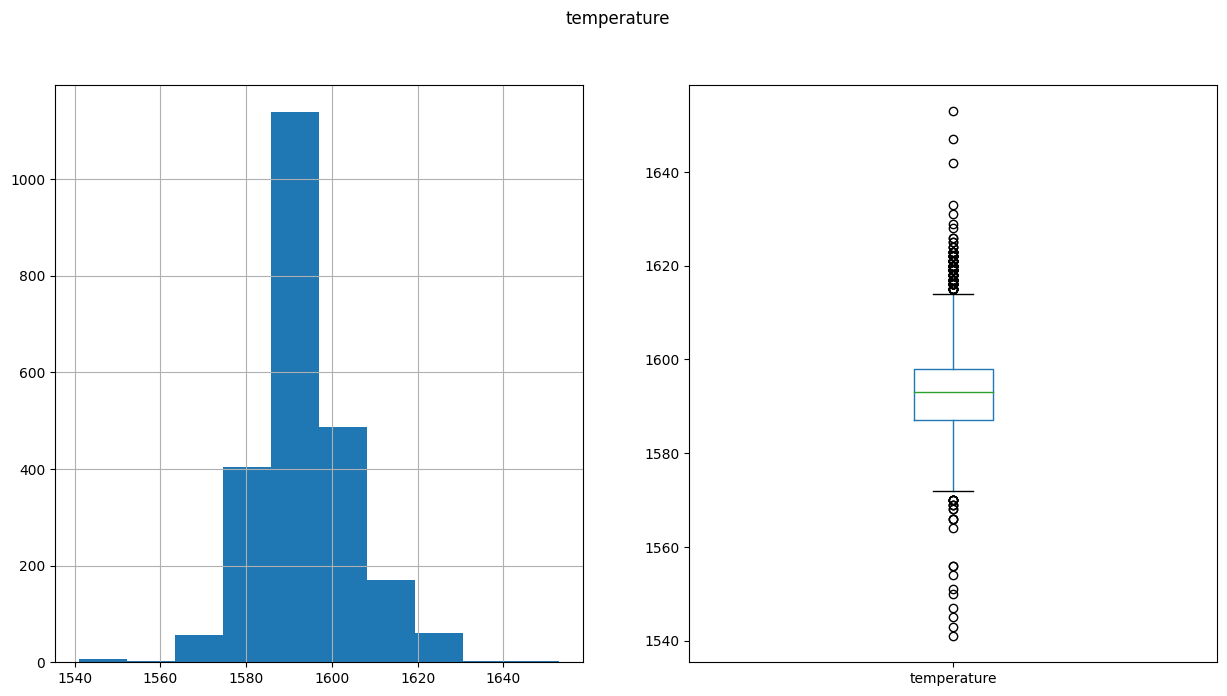

In [30]:
get_hist_and_boxplot(dataset['temperature'])

Наблюдаем нормальное распределение. 

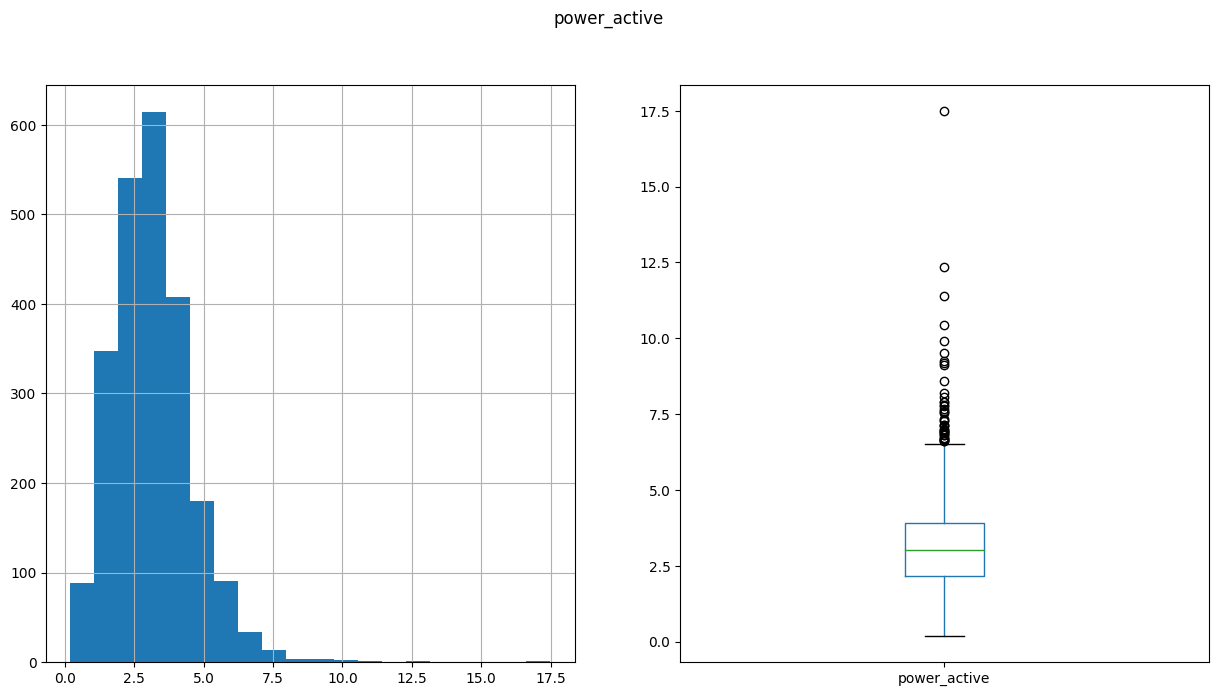

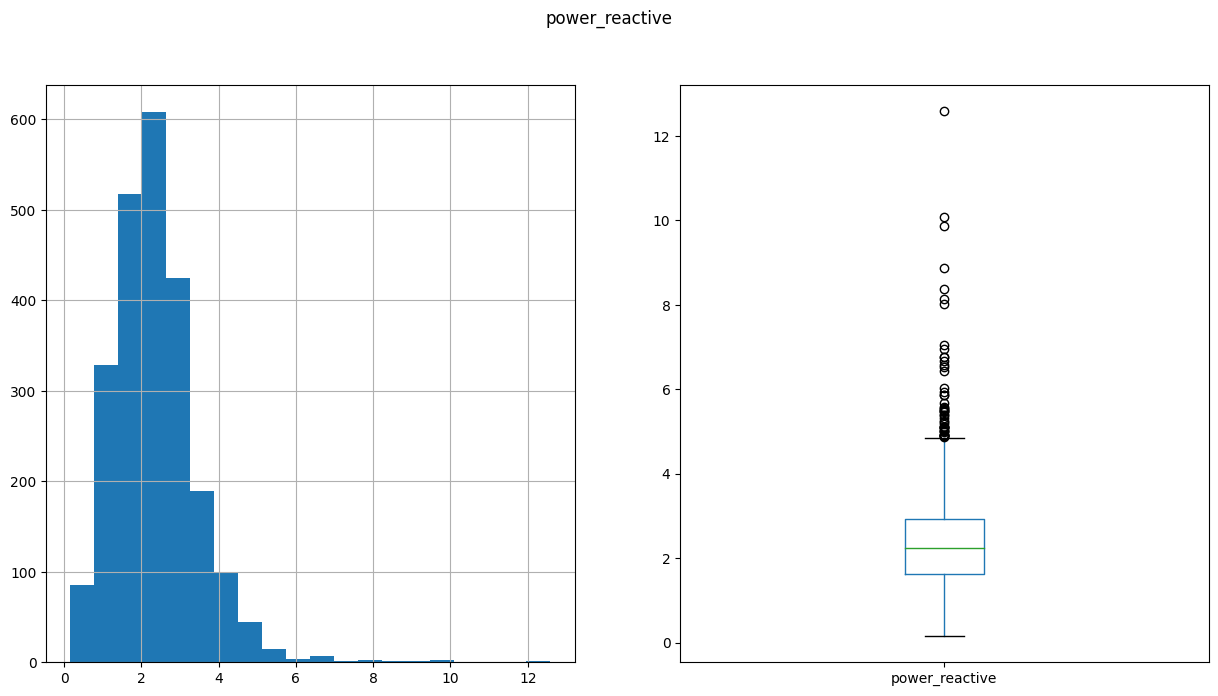

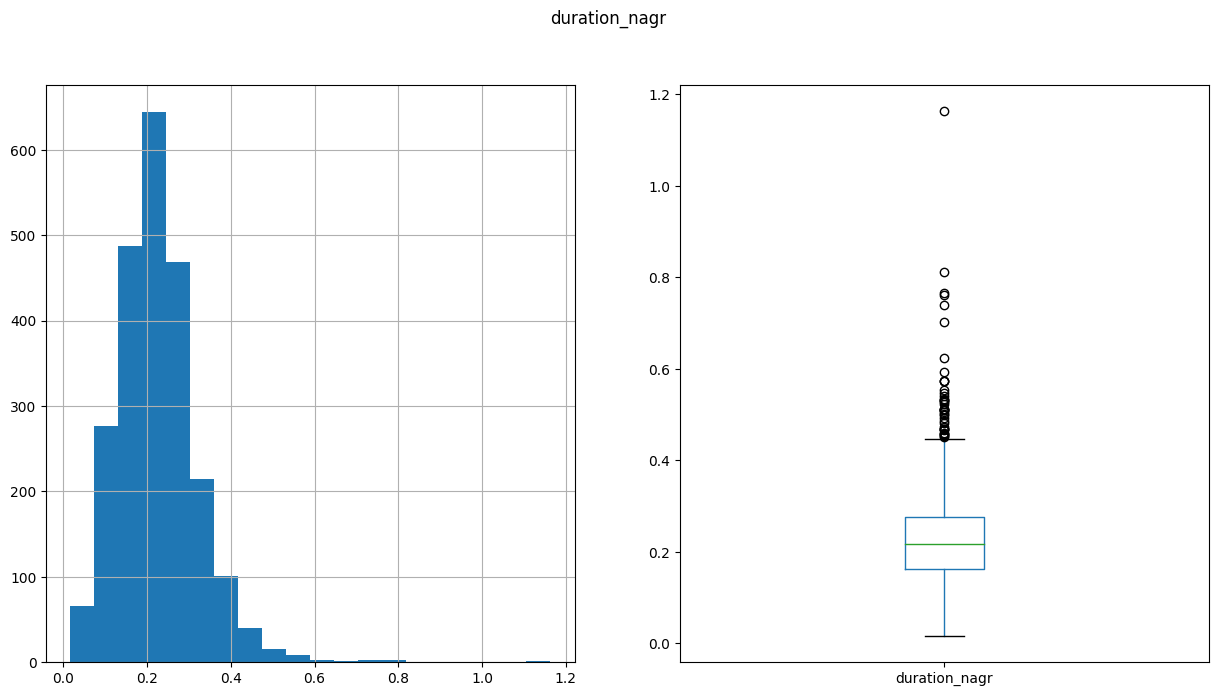

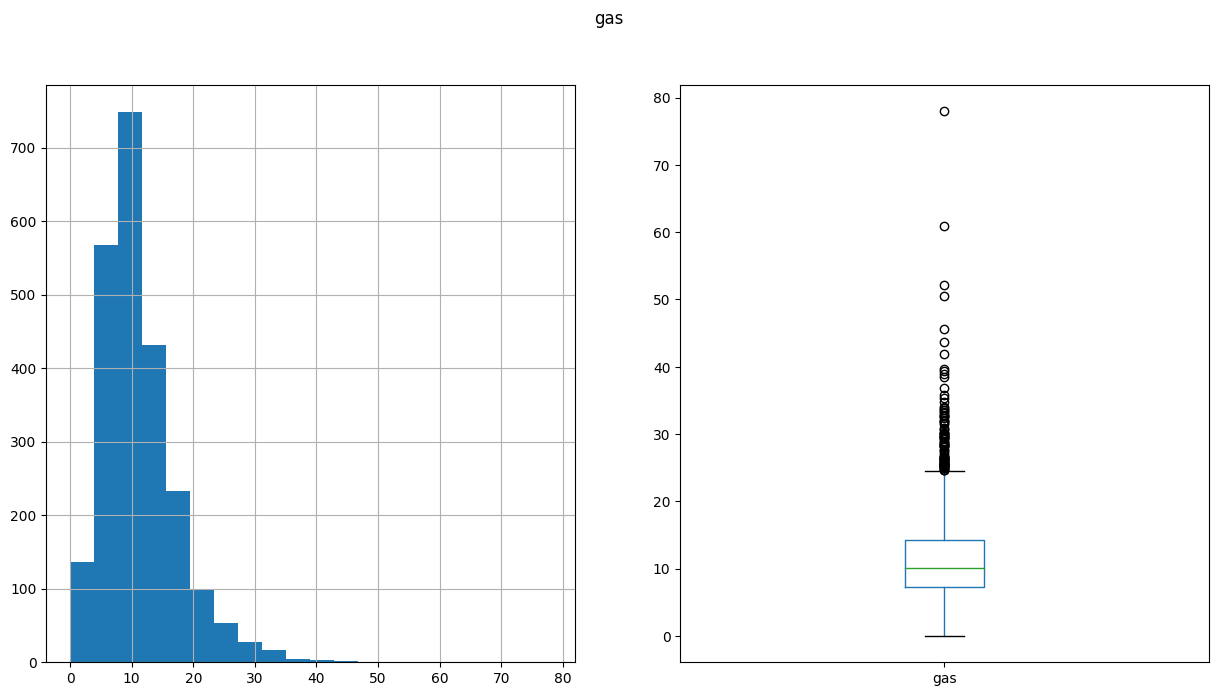

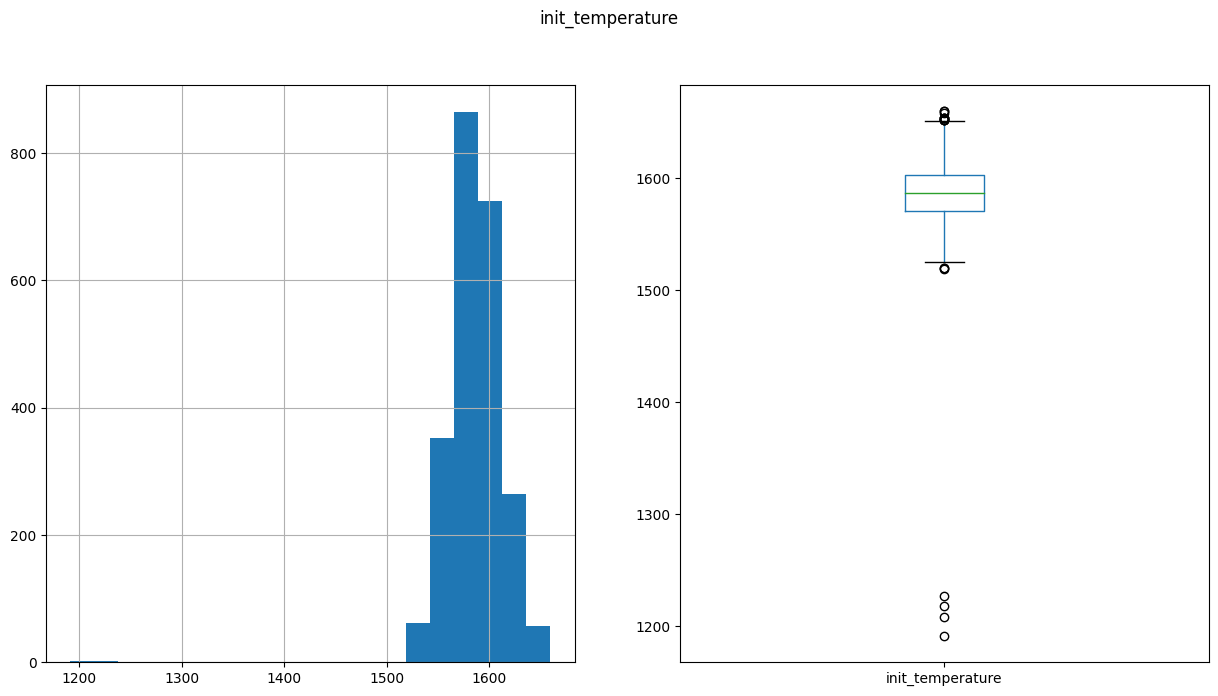

In [31]:
get_hist_and_boxplot(dataset['power_active'], bins = 20)
get_hist_and_boxplot(dataset['power_reactive'], bins = 20)
get_hist_and_boxplot(dataset['duration_nagr'], bins = 20)
get_hist_and_boxplot(dataset['gas'], bins = 20)
get_hist_and_boxplot(dataset['init_temperature'], bins = 20)

Везде, кроме начальной температуры наблюдаем нормальные распределения.  <br>
В начальной температуре, следует устранить выбросы вниз. 

In [32]:
dataset = dataset[dataset['init_temperature'] > 1300]
dataset_2 = dataset_2[dataset_2['init_temperature'] > 1300]

In [33]:
f'Теряем {round((init_len - dataset.shape[0]) / init_len * 100, 2)} % данных'

'Теряем 28.29 % данных'

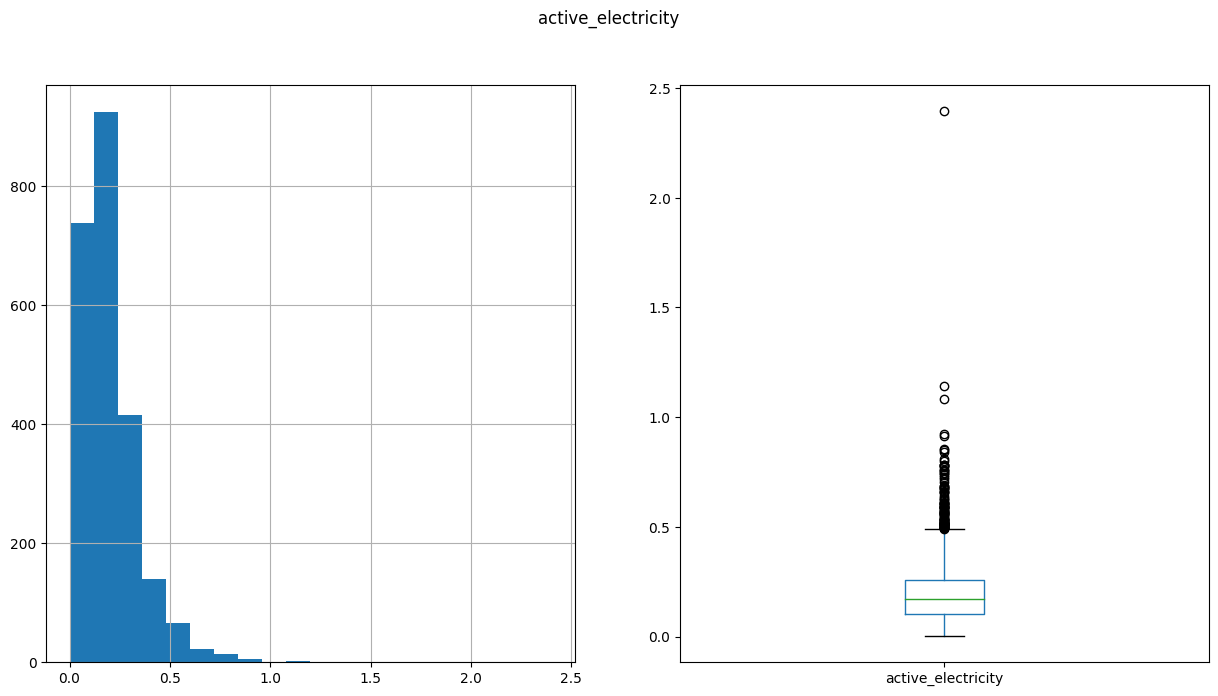

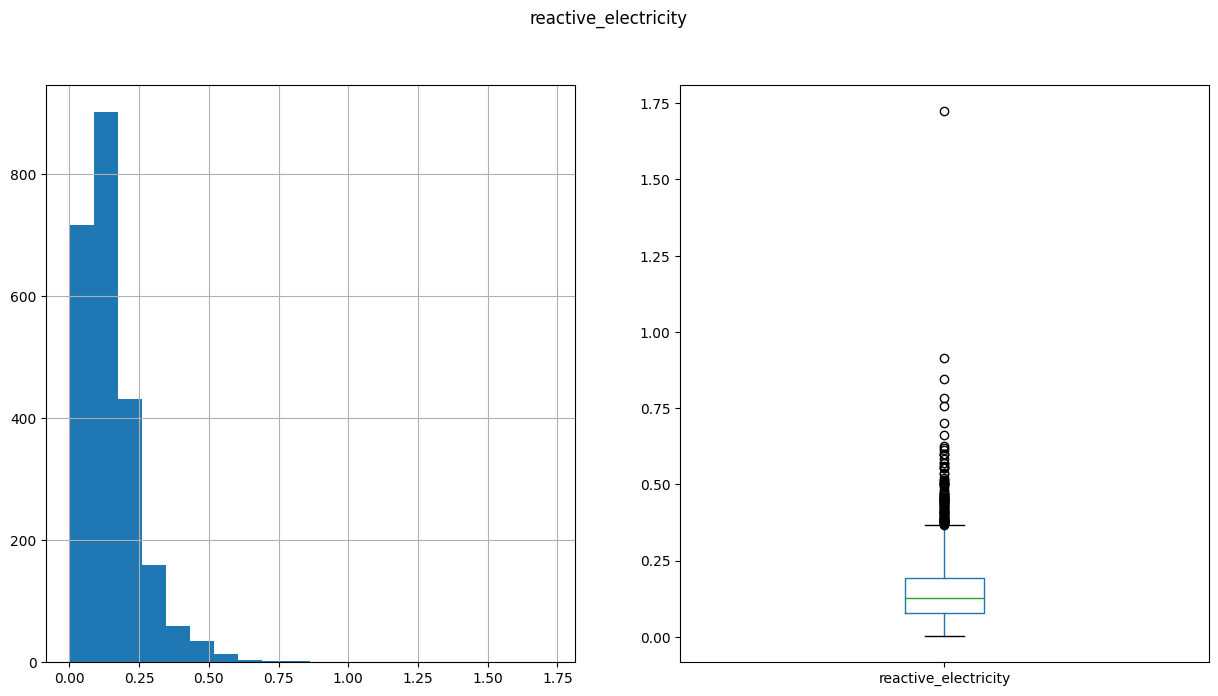

In [34]:
get_hist_and_boxplot(dataset_2['active_electricity'], bins = 20)
get_hist_and_boxplot(dataset_2['reactive_electricity'], bins = 20)

распределения скошены влево, поэтому возьмем логарифм: 

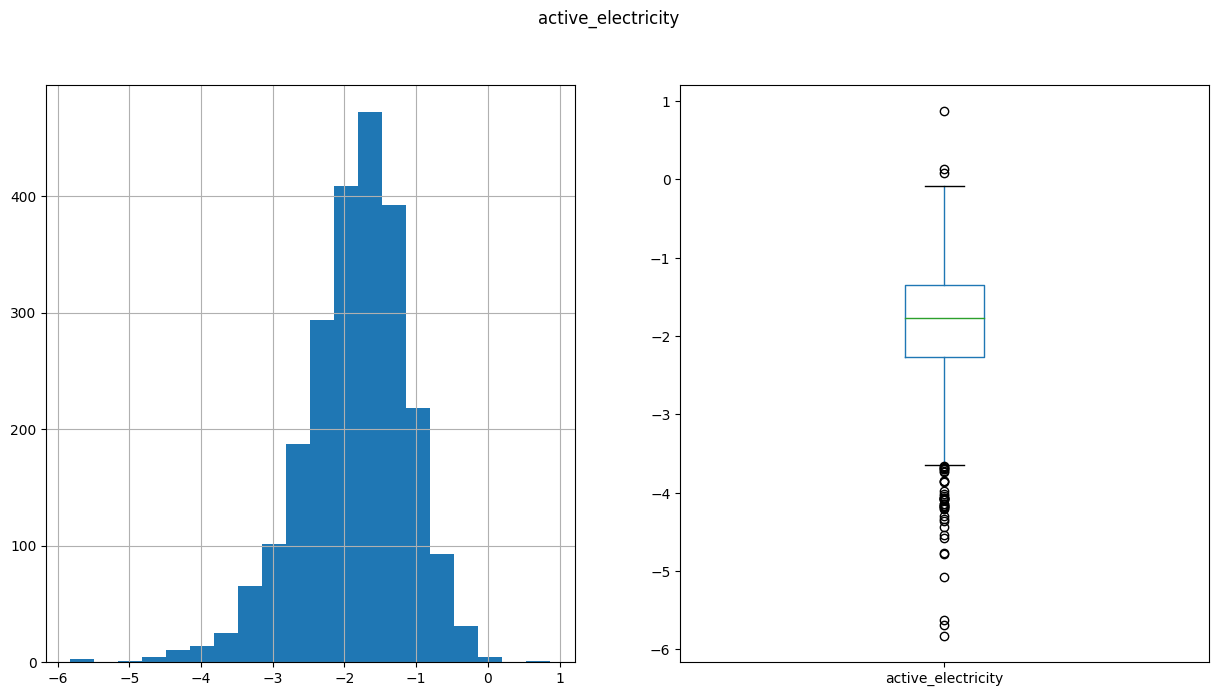

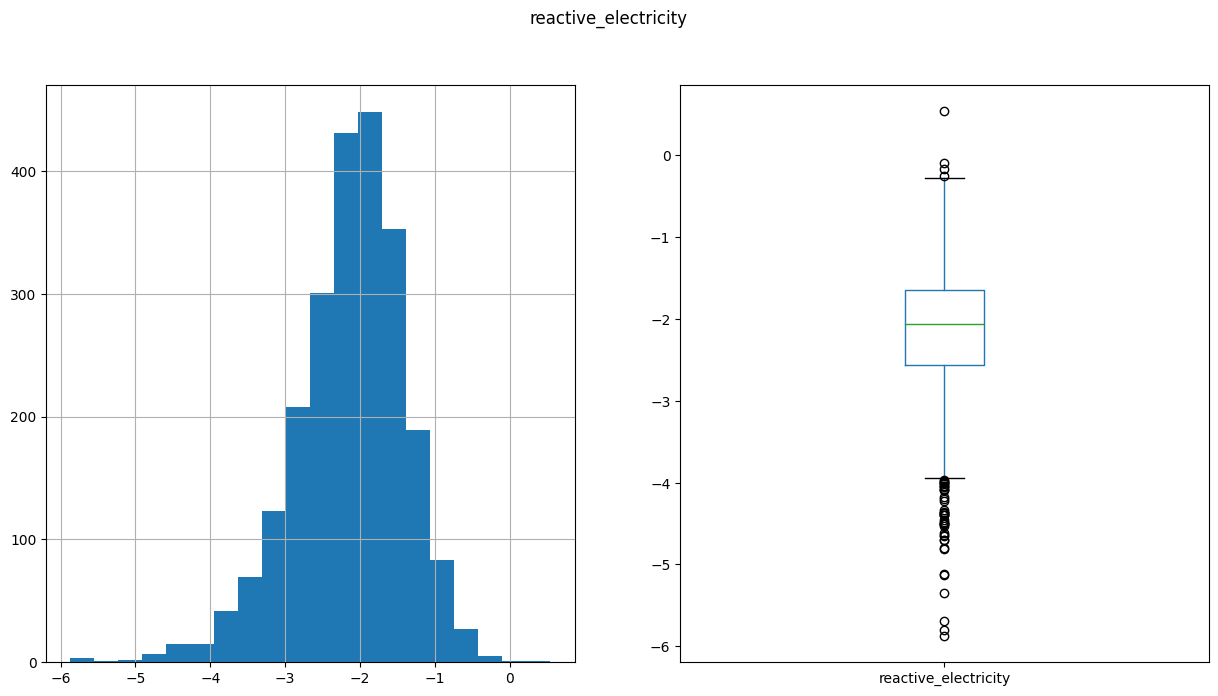

In [35]:
dataset_2['active_electricity'] = np.log(dataset_2['active_electricity'])
dataset_2['reactive_electricity'] = np.log(dataset_2['reactive_electricity'])

get_hist_and_boxplot(dataset_2['active_electricity'], bins = 20)
get_hist_and_boxplot(dataset_2['reactive_electricity'], bins = 20)

Полученное распределение является нормальным. 

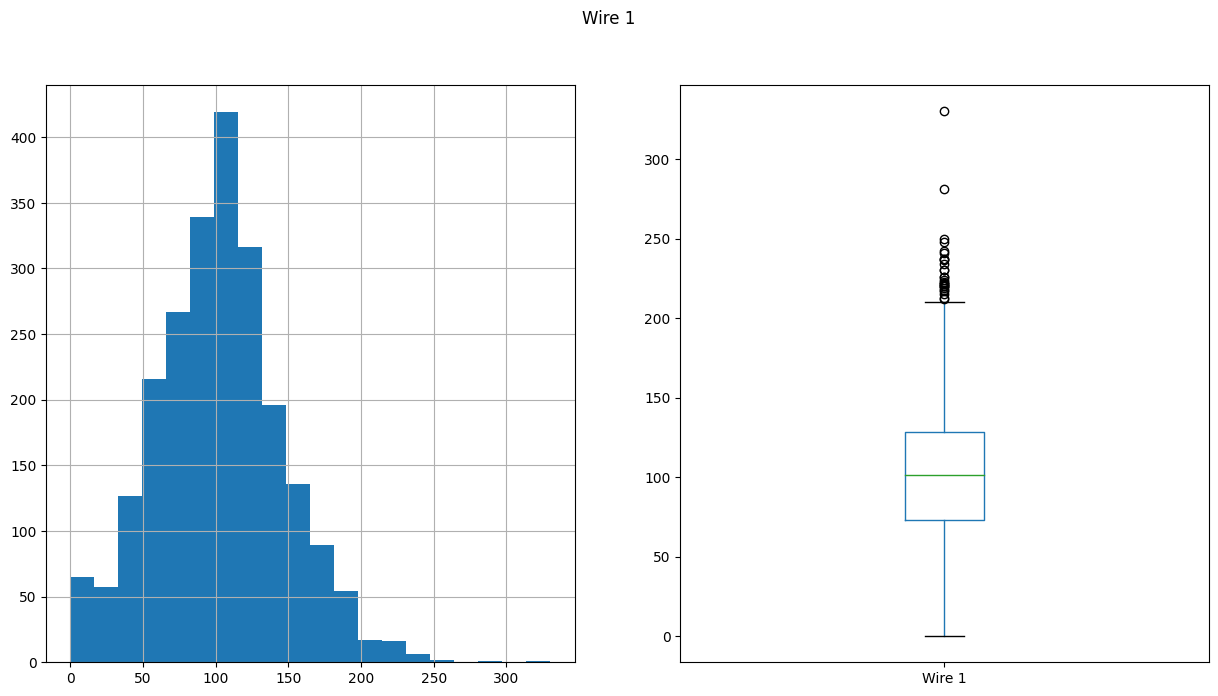

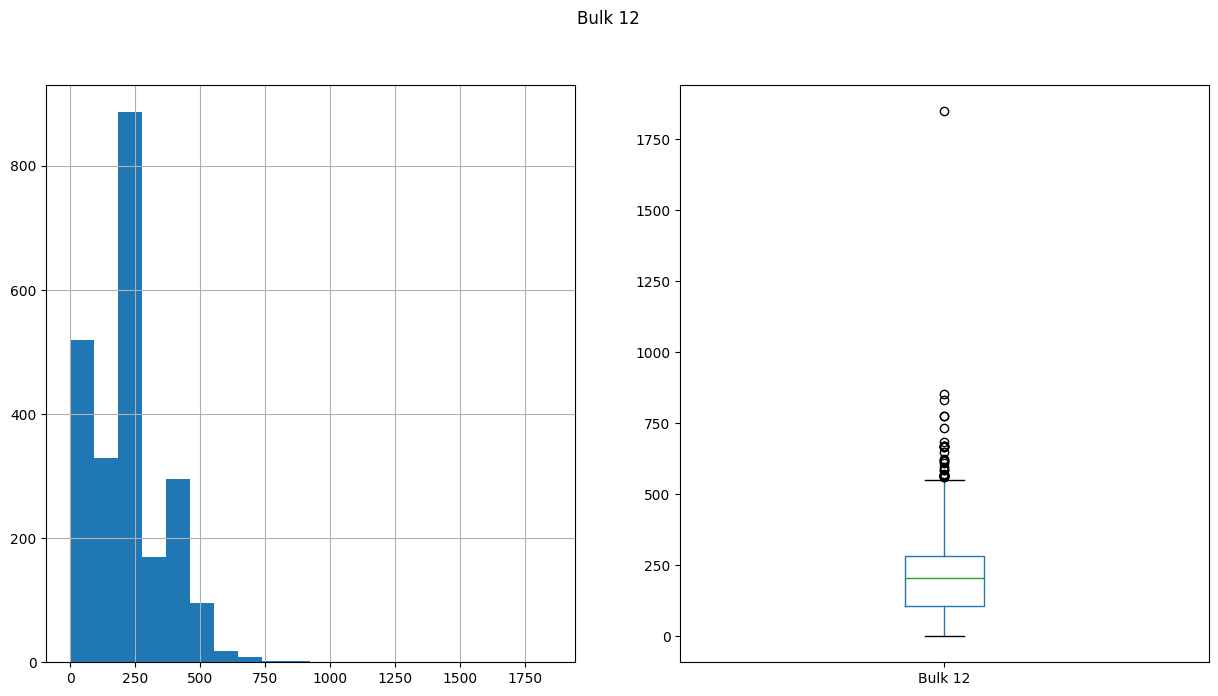

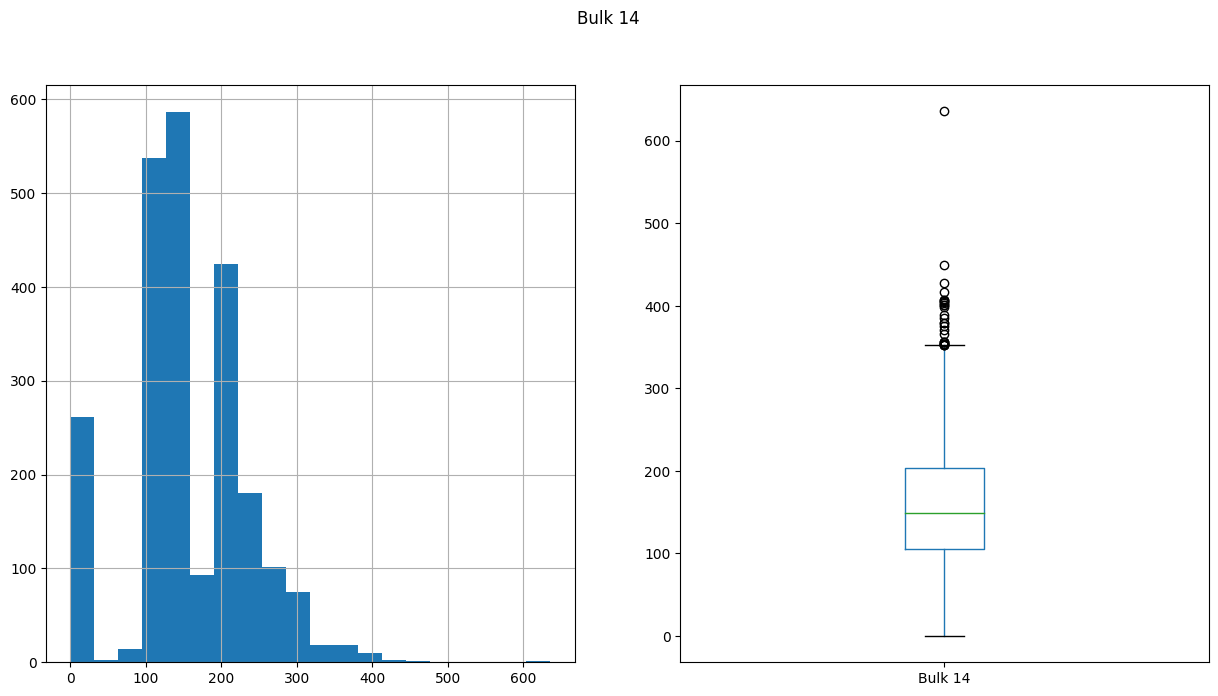

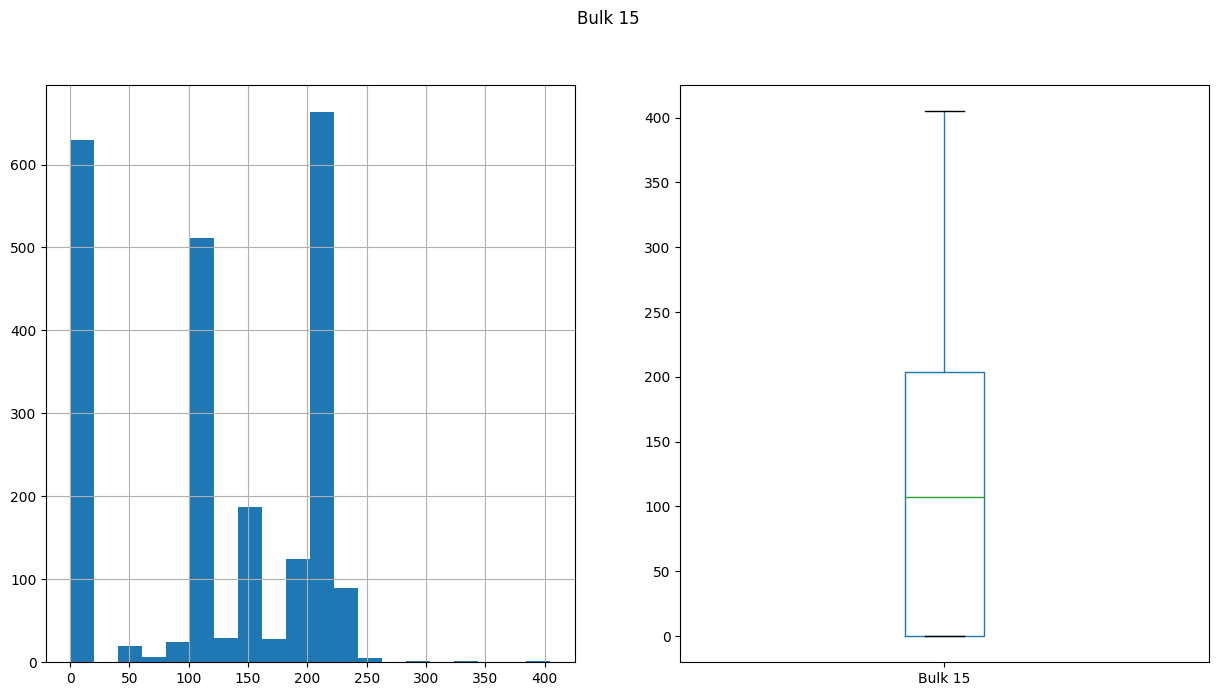

In [36]:
get_hist_and_boxplot(dataset['Wire 1'], bins = 20)
get_hist_and_boxplot(dataset['Bulk 12'], bins = 20)
get_hist_and_boxplot(dataset['Bulk 14'], bins = 20)
get_hist_and_boxplot(dataset['Bulk 15'], bins = 20)

Много нулевых значений. Все эти значения обязательно оставим, даже похожие на выборосы, потому что характеристика и объём примеси могут дать влияние на значение температуры

#### 1.3.2. Проверка на мультиколлиярность. 

Посмотрм какие признаки коррелируют между собой. 

<AxesSubplot:>

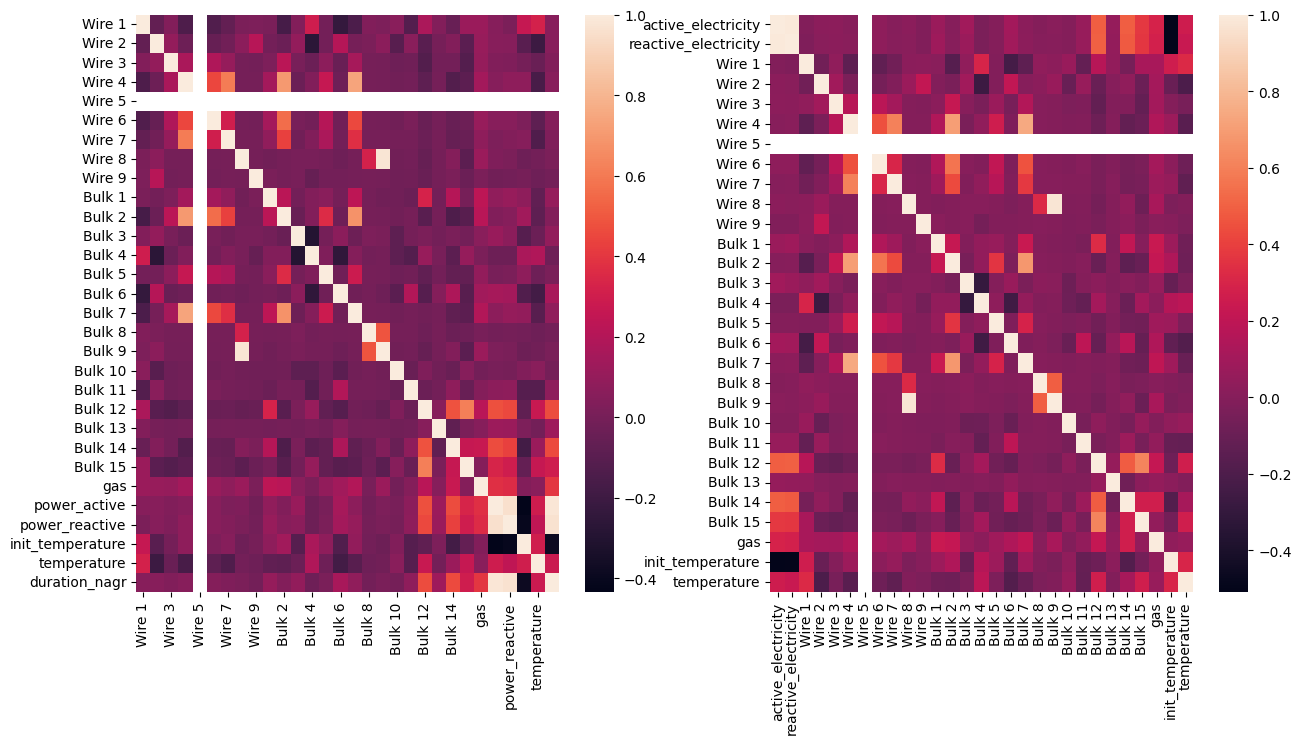

In [37]:
fig, ax = plt.subplots(1, 2, figsize = (15, 7.5))
sns.heatmap(dataset.corr(), ax = ax[0])
sns.heatmap(dataset_2.corr(), ax = ax[1])

Видимо, в стоблце Wire 5 мы имеем абслютно нулевые значения. Можем исключить его из анализа. 

In [38]:
dataset = dataset.drop(columns = ['Wire 5'])
dataset_2 = dataset_2.drop(columns = ['Wire 5'])

Отдельный интерес, какие признаки коррелируют с целевой переменой: 

In [39]:
pd.DataFrame([dataset.corr()['temperature'], dataset_2.corr()['temperature']]).T

,temperature,temperature
Wire 1,0.317488,0.317488
Wire 2,-0.207242,-0.207242
Wire 3,-0.047636,-0.047636
Wire 4,-0.159839,-0.159839
Wire 6,-0.084149,-0.084149
Wire 7,-0.137349,-0.137349
Wire 8,-0.010818,-0.010818
Wire 9,-0.027561,-0.027561
Bulk 1,-0.075428,-0.075428
Bulk 2,-0.082543,-0.082543


Самые коррелирующие признаки это (граница в 0.24) : 
- init_temperature
- duration_nagr, power_active, power_reactive ( и соответственно им active_electricity и reactive_electricity из другого датасета)
- Wire 1
- Bulk 15

### 1.4. Вывод по первому разделу.

По исходным данных от заказчика скомпонован датасет для моделирования. 

Из-за пробелов с замером последней температуры было исключено 28.26 % данных. 

Выявлены сильные признаки:
* init_temperature
* duration_nagr, power_active, power_reactive ( и соответственно им active_electricity и reactive_electricity из другого датасета)
* Wire 1
* Bulk 15



## 2. Моделирование.

И так, у нас есть два датасета. И я взял 4 модели. Переберем всё это.

### 2.1. Разделение данных на выборки. 

Тестовую выборку делаем 20%. 

In [40]:
train, test = train_test_split(dataset, test_size = 0.2, random_state = 12092022)
train_2, test_2 = train_test_split(dataset_2, test_size = 0.2, random_state = 12092022)

In [41]:
features_train = train.drop(columns = ['temperature'])
target_train = train['temperature']

features_test = test.drop(columns = ['temperature'])
target_test = test['temperature']

features_train_2 = train_2.drop(columns = ['temperature'])
target_train_2 = train_2['temperature']

features_test_2 = test_2.drop(columns = ['temperature'])
target_test_2 = test_2['temperature']

Создадим переменные для наполенения отчёта. 

In [42]:
result = pd.DataFrame()
list_model = []

scaler = StandardScaler()

### 2.2. Обучение моделей

#### 2.2.1. Линейная регрессия

Применим линейный принцип. Применим кросс-валидацию. 

In [43]:
model = LinearRegression()

pipe = Pipeline([('scaler',  scaler),
                 ('estimator', model)])

parameters = {'estimator__positive' : [True, False]}

apply_search_param_model(pipe, parameters, features_train, target_train, '1')
apply_search_param_model(pipe, parameters, features_train_2, target_train_2, '2')

Best: -6.012474 using {'estimator__positive': False}
Best: -6.012474 using {'estimator__positive': False}


#### 2.2.2. RandomForestRegressor

Применим другой принцип. А также устроим поиск гиперпараметров и кросс-валидацию и запишем только лучший результат. 

In [44]:
model = RandomForestRegressor()

pipe = Pipeline([('scaler',  scaler),
                 ('estimator', model)])

parameters = {'estimator__max_depth' : range(10, 21, 5),
              'estimator__n_estimators' : range(200, 401, 200)
             }

apply_search_param_model(pipe, parameters, features_train, target_train, '1')
apply_search_param_model(pipe, parameters, features_train_2, target_train_2, '2')

Best: -5.810072 using {'estimator__max_depth': 15, 'estimator__n_estimators': 200}
Best: -5.824260 using {'estimator__max_depth': 15, 'estimator__n_estimators': 400}


#### 2.2.3. CatBoost

Модель с градиентным бустингом. А также кросс-валидация, подбор гипер-параметров. 

In [45]:
model = CatBoostRegressor()

pipe = Pipeline([('scaler',  scaler),
                 ('estimator', model)])

parameters = {'estimator__loss_function': ['MAE'],
              'estimator__depth': [4, 7, 10],
              'estimator__learning_rate' : [0.01, 0.1],
              'estimator__verbose' : [False]}

apply_search_param_model(pipe, parameters, features_train, target_train, '1')
apply_search_param_model(pipe, parameters, features_train_2, target_train_2, '2')

Best: -5.785156 using {'estimator__depth': 7, 'estimator__learning_rate': 0.01, 'estimator__loss_function': 'MAE', 'estimator__verbose': False}
Best: -5.785156 using {'estimator__depth': 7, 'estimator__learning_rate': 0.01, 'estimator__loss_function': 'MAE', 'estimator__verbose': False}


#### 2.2.4. Нейросеть. 

Построим нейросеть, обучим с кросс-валидацией. 

In [46]:
def keras_model(lr, loss, layer_1, activation_1):
    tmodel = Sequential()
    tmodel.add(Dense(units=layer_1, kernel_initializer='normal', activation = activation_1))
    tmodel.add(Dense(units=1, kernel_initializer='normal'))
    tmodel.compile(loss=loss, optimizer=Adam(lr), metrics=['mae'])

    return tmodel

In [47]:
model = KerasRegressor(build_fn=keras_model, verbose=2)
pipe = Pipeline([('scaler',  scaler),
                 ('estimator', model)])

parameters = {'estimator__loss': ['mean_absolute_error'],
              'estimator__layer_1': [28],
              'estimator__lr' : [0.1, 1],
              'estimator__epochs' : [500],
              'estimator__activation_1' : [None],
              'estimator__verbose' : [False]}

apply_search_param_model(pipe, parameters, features_train, target_train, '1')
apply_search_param_model(pipe, parameters, features_train_2, target_train_2, '2')


2022-09-22 07:08:54.083074: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-22 07:08:54.083115: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-22 07:08:54.083136: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-f50b7512-36ee-428c-8cdb-b96e47c79851): /proc/driver/nvidia/version does not exist
2022-09-22 07:08:54.083443: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Best: -15.473031 using {'estimator__activation_1': None, 'estimator__epochs'

### 2.3. Выбор модели и контрольная проверка

Посмотрим нашу сводную таблицу лучших моделей: 

In [48]:
result.sort_values(by = 'score', ascending = False)

,name_model,parametrs,score,used_dataset
4,CatBoostRegressor,"{'estimator__depth': 7, 'estimator__learning_r...",-5.785156,1
5,CatBoostRegressor,"{'estimator__depth': 7, 'estimator__learning_r...",-5.785156,2
2,RandomForestRegressor,"{'estimator__max_depth': 15, 'estimator__n_est...",-5.810072,1
3,RandomForestRegressor,"{'estimator__max_depth': 15, 'estimator__n_est...",-5.824260,2
0,LinearRegression,{'estimator__positive': False},-6.012474,1
1,LinearRegression,{'estimator__positive': False},-6.012474,2
7,KerasRegressor,"{'estimator__activation_1': None, 'estimator__...",-15.280780,2
6,KerasRegressor,"{'estimator__activation_1': None, 'estimator__...",-15.473031,1


Лучшую метрику показала модель CatBoost, проведем контрольную проверку с 1 датасетом: 

In [49]:
best_model = list_model[result.sort_values(by = 'score', ascending = False).index[0]]
best_score = mean_absolute_error(best_model.predict(features_test), target_test)
print(f'MAE = {best_score}')

MAE = 6.240284920361252


### 2.4. Проверка значимости признаков

<AxesSubplot:xlabel='value', ylabel='features'>

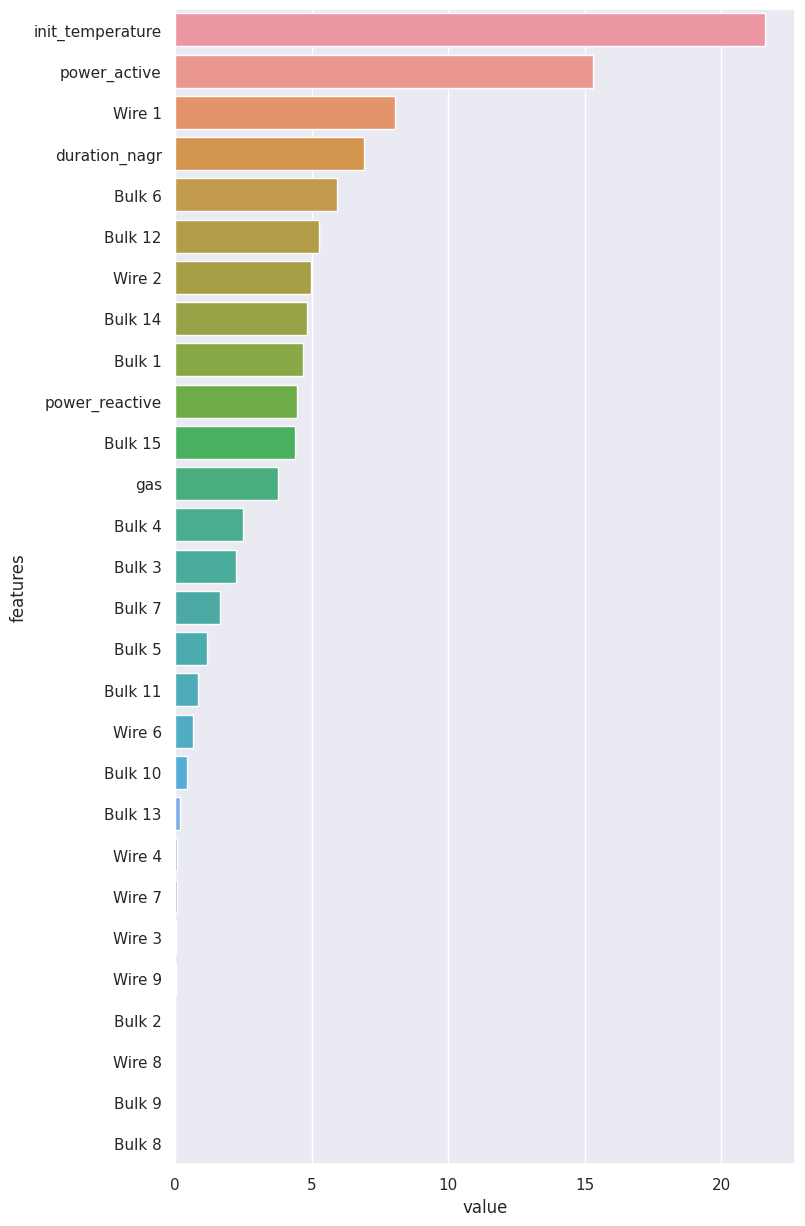

In [50]:
features_importance = (pd.DataFrame(zip(features_train.columns, 
                                        best_model.best_estimator_.steps[1][1].get_feature_importance()), 
                                        columns = ['features', 'value'])
                                    .set_index('features')
                                    .sort_values(by = 'value', ascending = False))
sns.set(rc={'figure.figsize':(8,15)})
sns.barplot(y = features_importance.index, x = features_importance['value'])

Очень много признаков вносят очень маленькое влияние. Выставим границу значимости в 5. Удалим лишние признаки и проведем повторные тесты на модели где будут лишь значимые признаки. 

In [51]:
features_importance_list = list(features_importance[features_importance['value'] > 5].index)
features_importance_list.append('temperature')
dataset_final = dataset.loc[:, features_importance_list]
train_final, test_final = train_test_split(dataset_final, test_size = 0.2, random_state = 12092022)

train_final_features= train_final.drop(columns = ['temperature'])
train_final_target = train_final['temperature']

test_final_features= test_final.drop(columns = ['temperature'])
test_final_target = test_final['temperature']
scaler_final = StandardScaler()
model_final = CatBoostRegressor()

pipe_final = Pipeline([('scaler',  scaler_final),
                 ('estimator', model_final)])

dict_best_params = {}
for key, value in best_model.best_params_.items():
    dict_best_params[key] = [value]

parameters = dict_best_params

search_model = GridSearchCV(estimator = pipe_final,
                            param_grid = parameters,
                            cv = 5, return_train_score=True, 
                            scoring = 'neg_mean_absolute_error', 
                            error_score='raise')

search_model.fit(train_final_features, train_final_target)

print("Best: %f using %s" %(search_model.best_score_, search_model.best_params_))
best_score_after = mean_absolute_error(search_model.predict(test_final_features), test_final_target)
print(f'MAE = {best_score_after}, по сравнению с предыдущей на: {best_score - best_score_after}')

Best: -6.057326 using {'estimator__depth': 7, 'estimator__learning_rate': 0.01, 'estimator__loss_function': 'MAE', 'estimator__verbose': False}
MAE = 6.249703253002262, по сравнению с предыдущей на: -0.009418332641009997


Метрика не изменилась практически и на тесте показала аналогичное значение, что следовательно, мы отбросили правильные признаки. 

<AxesSubplot:xlabel='value', ylabel='features'>

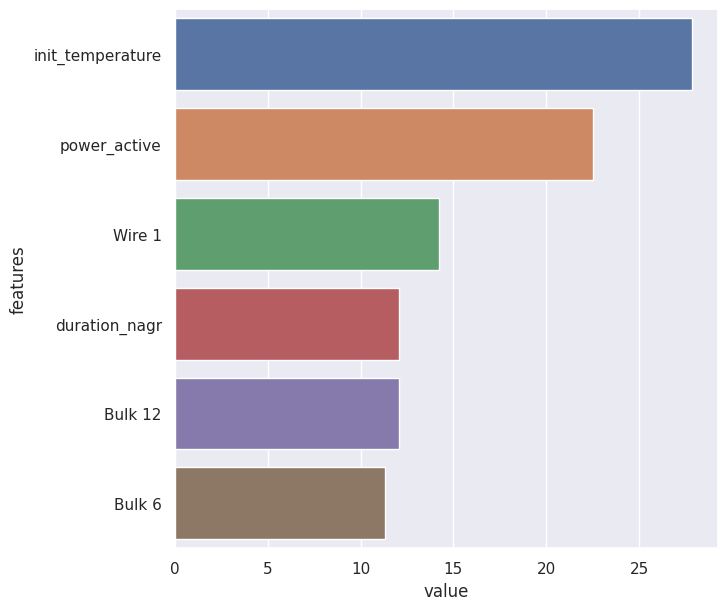

In [52]:
features_importance = (pd.DataFrame(zip(train_final_features.columns, 
                                        search_model.best_estimator_.steps[1][1].get_feature_importance()), 
                                        columns = ['features', 'value'])
                                    .set_index('features')
                                    .sort_values(by = 'value', ascending = False))
sns.set(rc={'figure.figsize':(7,7)})
sns.barplot(y = features_importance.index, x = features_importance['value'])

Заказчику важно следить за: 
* Начальной температурой сплава;
* Активной мощностью;
* Продолжительность нагрева;
* Объём подачи проволочного материала Wire 1;
* Объём подачи сыпучего материала Builk 12;
* Объём подачи сыпучего материала Builk 6.

### 2.5. Вывод по второму разделу. 

Главные моменты: 
* Линейная модель на валидационной выборке уже показывает хорошую метрику, что означает , что данные хорошо подготовлены;
* Нейронная сеть данную задачу не решает;
* Лучшая модель это CatBoost с метрикой на тесте MAE = 6.24;
* Определены и проверены важные признаки. 

## 3. Отчёт по проделанной работе

Перед нами предстояла следующая __цель__: 
Оптимизировать производственные расходы, уменьшить потребление электроэнергии на этапе обработки стали. 
Построить модель, которая предскажет температуру стали.

Для решения задачи были предприняты следующие шаги: <br>
* Предобработка данных:
        --- Выявлены артефактные значения в реактивной энергии, поэтому была была исключена одна партия вовсе;
        --- Пропущенные значения в объёмах подачи материалов заполнены нулём;
        --- Исходные данные с временем подачи сыпучих и проволочных материалов не были взяты в анализ;
        --- Собраны два новых датасета для моделирования;
        --- В новых датасетах, были исключены из анализа партии, не имеющие финального замера температуры и устранены 
        выбросы в замерах начальной температуры, что  привело к потере 28.29 % всего данных; 
        --- Мультиколлиярности не выявлено, но признак 'Wire 5' был исключен из анализа, потому что не имеет значений. 
* Моделирование: <br>
Изначально была цель, взять две базовые модели на разных принципах - LinearRegression ( построение линейной гиперплоскости) и RandomForestRegressor (построение решающих деревьев), оценить их результат. Далее применить модель с градиентным бустингом CatBoostRegressor для увеличения качества модели. И планировалось, что самой сильной моделью выступит нейронная сеть на KerasRegressor. Но нейронная сеть здесь не сработала. <br>
Все эксперименты проводились по такому сценарию: <br>
Подготовленный датасет -> __Pipeline__ (применяем здесь только масштабирование) -> __GridSearchCV__ (здесь подбираем гиперпараметры модели и кросс-валидация) -> Получаем метрику __MAE по модели с наилучшими гиперпараметрами__. 

Результат моделирования представлен на графике: <br>
По оси х отмечено значения метрики MAE. <br>
По оси y отмечена наименование модели и значение в конце, какой датасет используется. 

<AxesSubplot:xlabel='score'>

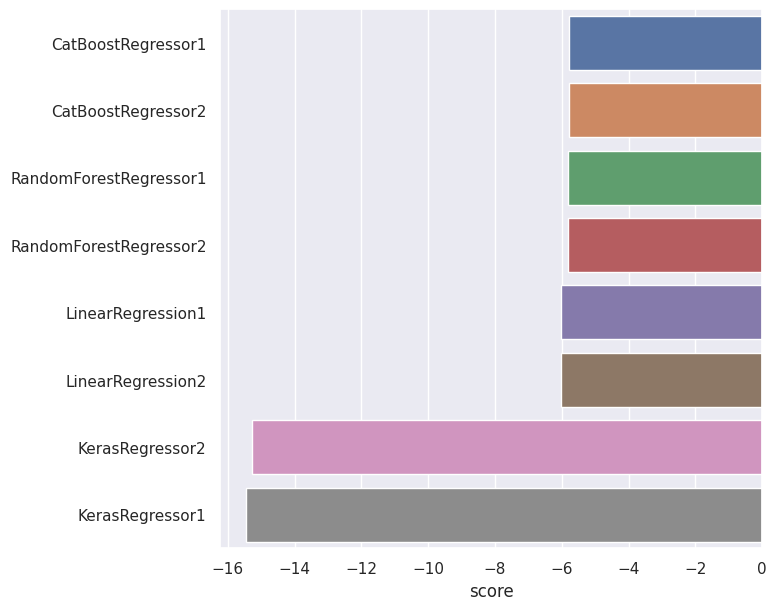

In [53]:
result = result.sort_values(by = 'score', ascending = False)
sns.set(rc={'figure.figsize':(7,7)})
sns.barplot(y = (result['name_model'] + result['used_dataset']), x = result['score'])

Была выбрана модель CatBoostRegressor, которая показала наименьшую метрику MAE = 6.24 на контрольной проверке. 

После была проведена оценка важности факторов в модели, результат представлен на графике: 

<AxesSubplot:xlabel='value', ylabel='features'>

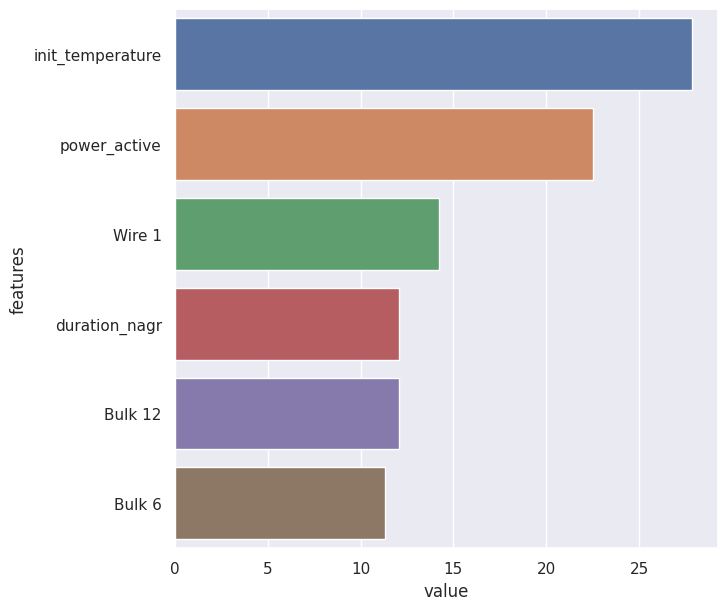

In [54]:
sns.set(rc={'figure.figsize':(7,7)})
sns.barplot(y = features_importance.index, x = features_importance['value'])

как отмечалось раннее, заказчику важно следить за следующими параметрами для контроля температуры: <br>
* Начальной температурой сплава;
* Активной мощностью;
* Продолжительность нагрева;
* Объём подачи проволочного материала Wire 1;
* Объём подачи сыпучего материала Builk 12;
* Объём подачи сыпучего материала Builk 6. <br>

Мы провели повторный контрольный замер, после удаления "неважных" признаков. Метрика изменилась в худшую сторону на 0.009. Это очень мало. Поэтому подверддаем, что эти признаки неважны. <br>


Теперь интерпретируем результат. <br>
По сути наша цель оптимизация расхода материалов и электроэнергии. Целевой признак мы можем заменить на изменение температуры (фильнальный замер - начальный замер) и если бы у нас была возможность перевести всё в денежный эквивалент, то мы могли бы вычислить, самый дешевый способ из комбинации входных параметров для получения большего нагрева. - тем самым задачу для снижения расходов, мы бы решили. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f50b7512-36ee-428c-8cdb-b96e47c79851' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>